In [87]:
from cairosvg import svg2png
from io import BytesIO
from os import listdir
from PIL import Image
from subprocess import DEVNULL, STDOUT, check_call
from tqdm import tqdm
from skimage.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
import re

In [9]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
def svg_to_image(string, scale=1):
    image = svg2png(bytestring=string, write_to=None, scale=scale)
    return Image.open(BytesIO(image))

In [3]:
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text)]

In [92]:
def calculate_loss(file, actor="actor.pkl", corner_radius=True):
    img = Image.open(file)
    size = min(img.size)
    img = img.crop((0, 0, size, size))
    img.resize((128, 128)).save("unsplash_input.png", "PNG")
    img_scaled = np.array(img.resize((1024, 1024)))
    
    cr = ['--corner_radius'] if corner_radius else []
    
    check_call(
        ['python3', 'baseline/test.py', '--max_step=250', '--actor=' + actor, '--img=unsplash_input.png'] + cr, 
        stdout=DEVNULL, 
        stderr=STDOUT
    )
    
    directory = 'output/'
    
#     svg = open(directory + 'vector_generated624.svg').read().encode('utf-8')
#     generated = svg_to_image(svg, scale=8).convert("RGBA")
    
#     res = Image.new("RGB", (1024, 1024), (255, 255, 255))
#     res.paste(generated, mask=generated)
#     res = np.asarray(res)
    
#     return ((res - img_scaled) ** 2).mean()

    loss = []
    for filename in sorted(listdir(directory), key=natural_keys):
        if not filename.endswith('svg'):
            continue

        svg = open(directory + filename).read().encode('utf-8')
        generated = svg_to_image(svg, scale=8).convert("RGBA")

        res = Image.new("RGB", (1024, 1024), (255, 255, 255))
        res.paste(generated, mask=generated)
        res = np.asarray(res)

        loss.append(mse(res, img_scaled))
    return np.array(loss)

In [93]:
loss = []
for filename in tqdm(listdir('unsplash/'), desc='dirs'):
    if not filename.endswith('jpg'):
        continue
    
    loss.append(calculate_loss('unsplash/' + filename))

dirs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [1:54:48<00:00, 149.76s/it]


In [94]:
loss_a = []
for filename in tqdm(listdir('unsplash/'), desc='dirs'):
    if not filen came.endswith('jpg'):
        continue
    
    loss_a.append(calculate_loss('unsplash/' + filename, "actor_a.pkl", False))

dirs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [1:44:51<00:00, 136.77s/it]


In [102]:
print(np.mean(loss, axis=0)[-1])
print(np.mean(loss_a, axis=0)[-1])

672.2318735053574
855.7928539289944


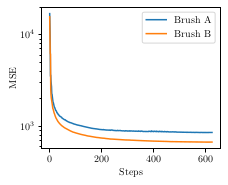

In [97]:
loss = np.array(loss)
loss_a = np.array(loss_a)

plt.figure(figsize=(3.2, 2.6))

plt.ylabel("MSE")
plt.xlabel("Steps")

plt.plot(loss_a.mean(axis=0), label='Brush A')
plt.plot(loss.mean(axis=0), label='Brush B')

plt.legend()
plt.yscale('log')
plt.savefig('photography_x.pgf', bbox_inches='tight')

In [ ]:
plt.savefig('photos.pgf')

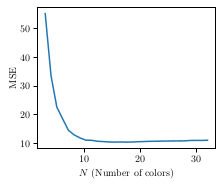

In [74]:
import json

f = open('potrace_color.json', "r")

loss2 = np.array(json.loads(f.read()))
x = np.linspace(3, 32, 29)

plt.figure(figsize=(3.2, 2.6))

plt.plot(x, loss2.mean(axis=0))
plt.ylabel("MSE")
plt.xlabel("$N$ (Number of colors)")
plt.savefig('potrace_color.pgf', bbox_inches='tight')